# Make a Survey Overview

**Goal**: Make a nice of all the data on a nice DEM 

**Approach**: 

1. Create an overview DEM with hillShade
2. Grab locations of single location type data
3. Grab centroids of all the raster tiles
4. Plot it all!

## Process:

### Step 1. Create an Overview Raster with HillShade

In [5]:
from snowexsql.db import get_db
from snowexsql.data import ImageData, LayerData, PointData, SiteData 
from snowexsql.conversions import raster_to_rasterio
from rasterio.plot import show
from sqlalchemy.sql import func
from geoalchemy2.types import Raster
import geoalchemy2.functions as gfunc
import matplotlib.pyplot as plt 
import geopandas as gpd
from shapely.geometry import Polygon
from geoalchemy2.shape import from_shape, to_shape

# Connect to the database we made.
db_name = 'db.snowexdata.org/snowex'
engine, session = get_db(db_name, credentials='./credentials.json')

# DEM data name and surveyor
data_name = 'DEM'
observers = 'USGS'

# Resolution to make our DEM/Hillshade
res = 20

# Form a polygon to clip at the max extent (figured out in advance)
x1 = 735200.0
x2 = 760000.0
y1 = 4319989.0
y2 = 4329803.0

extent = Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]])       # Construct it using shapely

# Make the polygon usable to the db
extent_ewkt = from_shape(extent, srid=26912).ST_AsEWKT()

# Make polygon plottable for later
extent_df = gpd.GeoDataFrame({'geometry':[extent]})     

In [6]:
# Define a function to reduce the same code used for getting the dem and hillshade
def filter_and_return(session, base, data_name, observers, extent):
    '''
    Small function to apply redundent filters and raster making
    '''
    # Save our query as a Tiff and clip it along the extents polygon
    q = session.query(func.ST_AsTiff(func.ST_Clip(base, extent)))
    
    # Filter by data name and surveyor
    q = q.filter(ImageData.type == data_name)
    q = q.filter(ImageData.observers == observers)
    
    # Execute the query
    rasters = q.all()
    
    # Convert the dataset from the DB to rasterio
    dataset = raster_to_rasterio(session, rasters)[0]
    return dataset

In [7]:
# Create the base query to reduce code: Collect Rasters and rescale them to our resolution and use bilinear interpolation 
bq = func.ST_Rescale(ImageData.raster, res, -1 * res, 'blinear')

# Retrieve the dem, join all the tiles retrieved
base = gfunc.ST_Union(bq, type_=Raster) # Is NOT EXECUTED until query is executed.
dem = filter_and_return(session, base, data_name, observers, extent_ewkt) 

# Merge all the tiles retrieved, then make the hillshade.
base = func.ST_Hillshade(gfunc.ST_Union(bq, type_=Raster)) # Is NOT EXECUTED until query is executed.
hillshade = filter_and_return(session, base, data_name, observers, extent_ewkt)

ProgrammingError: (psycopg2.errors.UndefinedColumn) column images.observers does not exist
LINE 3: WHERE public.images.type = 'DEM' AND public.images.observers...
                                             ^

[SQL: SELECT ST_AsTIFF(ST_Clip(ST_Union(ST_Rescale(public.images.raster, %(ST_Rescale_1)s, %(ST_Rescale_2)s, %(ST_Rescale_3)s)), ST_AsEWKT(ST_GeomFromWKB(%(ST_GeomFromWKB_1)s, %(ST_GeomFromWKB_2)s)))) AS "ST_AsTIFF_1" 
FROM public.images 
WHERE public.images.type = %(type_1)s AND public.images.observers = %(observers_1)s]
[parameters: {'ST_Rescale_1': 20, 'ST_Rescale_2': -20, 'ST_Rescale_3': 'blinear', 'ST_GeomFromWKB_1': <memory at 0x7ff354c411c0>, 'ST_GeomFromWKB_2': 26912, 'type_1': 'DEM', 'observers_1': 'USGS'}]
(Background on this error at: http://sqlalche.me/e/14/f405)

### Step 2. Grab locations of single location type data

In [4]:
# Write a function to retrieve positional points of data
def grab_points(session, TableClass, data_name, distinct=False, instrument=None, downsample=None):
    """
    Returns a dataframe of geometric points of requested data. Use distinct to avoid collecting 
    identical locations from layer data. Use instrument to isolate snow depths
    
    Returns: df: Geopandas dataframe with one column geometry for plotting
    """
    q = session.query(TableClass.geom).filter(TableClass.type == data_name)
    
    if instrument != None:
        
        # Filter by what instruments are in a list provided
        if type(instrument) == list:
            q = q.filter(TableClass.instrument.in_(instrument))
        else:
            q = q.filter(TableClass.instrument == instrument)
    
    if downsample is not None:
        # Only sample some of the data 
        q = q.filter(TableClass.id % downsample == 0)
    if distinct:
        q = q.distinct()
    
    points = q.all()
    
    # Make the points into a geopandas dataframe so we can easily plot it
    df = gpd.GeoDataFrame({'geometry':[to_shape(p[0]) for p in points]})
    print('Found {} points for {}...'.format(len(df.index), data_name))
    return df

In [5]:

# Show all instruments used to gather snow depths
tools = session.query(PointData.instrument).filter(PointData.type == 'depth').distinct().all()

# Grab our pits by selecting hand hardness profiles
data = {}

# Use distinct locations from hand hardness profiles to get pit locations
pits = grab_points(session, LayerData, 'hand_hardness', distinct=True)

# Get distinct locations of smp profiles
smp = grab_points(session, LayerData, 'force', distinct=True)

# Grab all snow depths collected with magnaprobe, mesa, or a pit rule
depths = grab_points(session, PointData, 'depth', instrument=['magnaprobe', 'mesa'])

# Grab all the GPR point data
gpr = grab_points(session, PointData, 'two_way_travel', downsample=100)

# Grab all the camera locations point data
cameras = grab_points(session, PointData, 'depth', instrument=['camera'], distinct=True)


Found 155 points for hand_hardness...
Found 931 points for force...
Found 37754 points for depth...
Found 12649 points for two_way_travel...
Found 29 points for depth...


### Step 3. Grab centroids of all the raster tiles

In [6]:
# Define a function to grab the center of each raster tile
def get_tile_centers(session, data_name, observers=None):
    '''
    Simple function to grab the center of each tile given a data type and optionally a surveyor name
    '''
    # Use database to grab the centroid of each tile outline (envelope) filtering on type. Also return the surveyor.
    q = session.query(func.ST_Centroid(func.ST_Envelope(ImageData.raster))).filter(ImageData.type == data_name)
    
    # If observers is provided, filter on that too
    if observers != None:
        q = q.filter(ImageData.observers == observers)
    
    centers = q.all()
    
    # Form the data into plottable geopandas dataframe with only a geometry column
    df = gpd.GeoDataFrame({'geometry':[to_shape(p[0]) for p in centers]})
    print('Found {} tiles for {}...'.format(len(df.index), data_name))
    return df

In [7]:
# Grab all the names of the raster data so we know what to reference
names = session.query(ImageData.type).distinct().all()

# Use the get_tile_centers function to grab the dataframe containing the tile centroids and assign a color and marker to it for plotting
tiles = {}

# Grab all the ASO DEM centers, assign color as blue and use squares for symbols
tiles['ASO Depths'] = (get_tile_centers(session, 'depth', observers='ASO Inc.'), 'steelblue', 's')
# tiles['ASO SWE'] = (get_tile_centers(session, 'swe', observers='ASO Inc.'), 'plum', 's')

# Grab all the USGS DEM centers, assign color as light red and use pentagons for symbols
tiles['USGS DEM'] = (get_tile_centers(session, 'DEM', observers='USGS'), 'plum','p')

# Grab all the insar data centers, assign color as some shade of orange and use diamonds for symbols
tiles['INSAR Amplitudes'] = (get_tile_centers(session, 'insar amplitude'), 'gold', 'D')
tiles['INSAR Derived'] = (get_tile_centers(session, 'insar interferogram real'), 'goldenrod', 'D') # Since imaginary and real are in the same location we only need one of them
# tiles['INSAR Correlation.'] = (get_tile_centers(session, 'insar correlation'), 'bisque', 'D')

Found 256 tiles for depth...
Found 1713 tiles for DEM...
Found 1344 tiles for insar amplitude...
Found 672 tiles for insar interferogram real...


In [8]:
metadata = {'instrument': [], 'date':[],'doi':[]}

for k in metadata.keys():
    for tbl in [PointData, LayerData, ImageData]:
        print(f'Counting {k} in {tbl.__name__}...')
        
        metadata[k] += [v[0] for v in session.query(getattr(tbl,k)).filter(getattr(tbl,k).isnot(None)).distinct()]

    metadata[k] = list(set(metadata[k]))

# Find all observers (Temporarily not working because surveyor upload is incorrect)
metadata['observers'] = []

for tbl in [PointData, LayerData, ImageData]:
        print(f'Counting observers in {tbl.__name__}...')
        
    # Manage multiple names in the surveyor
        observers = session.query(tbl.observers).filter(tbl.observers.isnot(None)).distinct().all()
        for name in observers:
            if ',' in name[0] and 'JPL' not in name[0]:
                metadata['observers'] += name[0].split(',')
            elif '&' in name[0]:
                metadata['observers'] += name[0].split('&')
            else:
                metadata['observers'] += [name[0]]

metadata['observers'] = len(list(set(metadata['observers'])))
metadata['date'] = (min(metadata['date']).strftime('%Y-%m-%d'), max(metadata['date']).strftime('%Y-%m-%d'))
metadata['instrument'] = len(metadata['instrument'])
metadata['doi'] = len(metadata['doi'])


Counting instrument in PointData...
Counting instrument in LayerData...
Counting instrument in ImageData...
Counting date in PointData...
Counting date in LayerData...
Counting date in ImageData...
Counting doi in PointData...
Counting doi in LayerData...
Counting doi in ImageData...
Counting surveyors in PointData...
Counting surveyors in LayerData...
Counting surveyors in ImageData...


### Step 4. Plot it all!

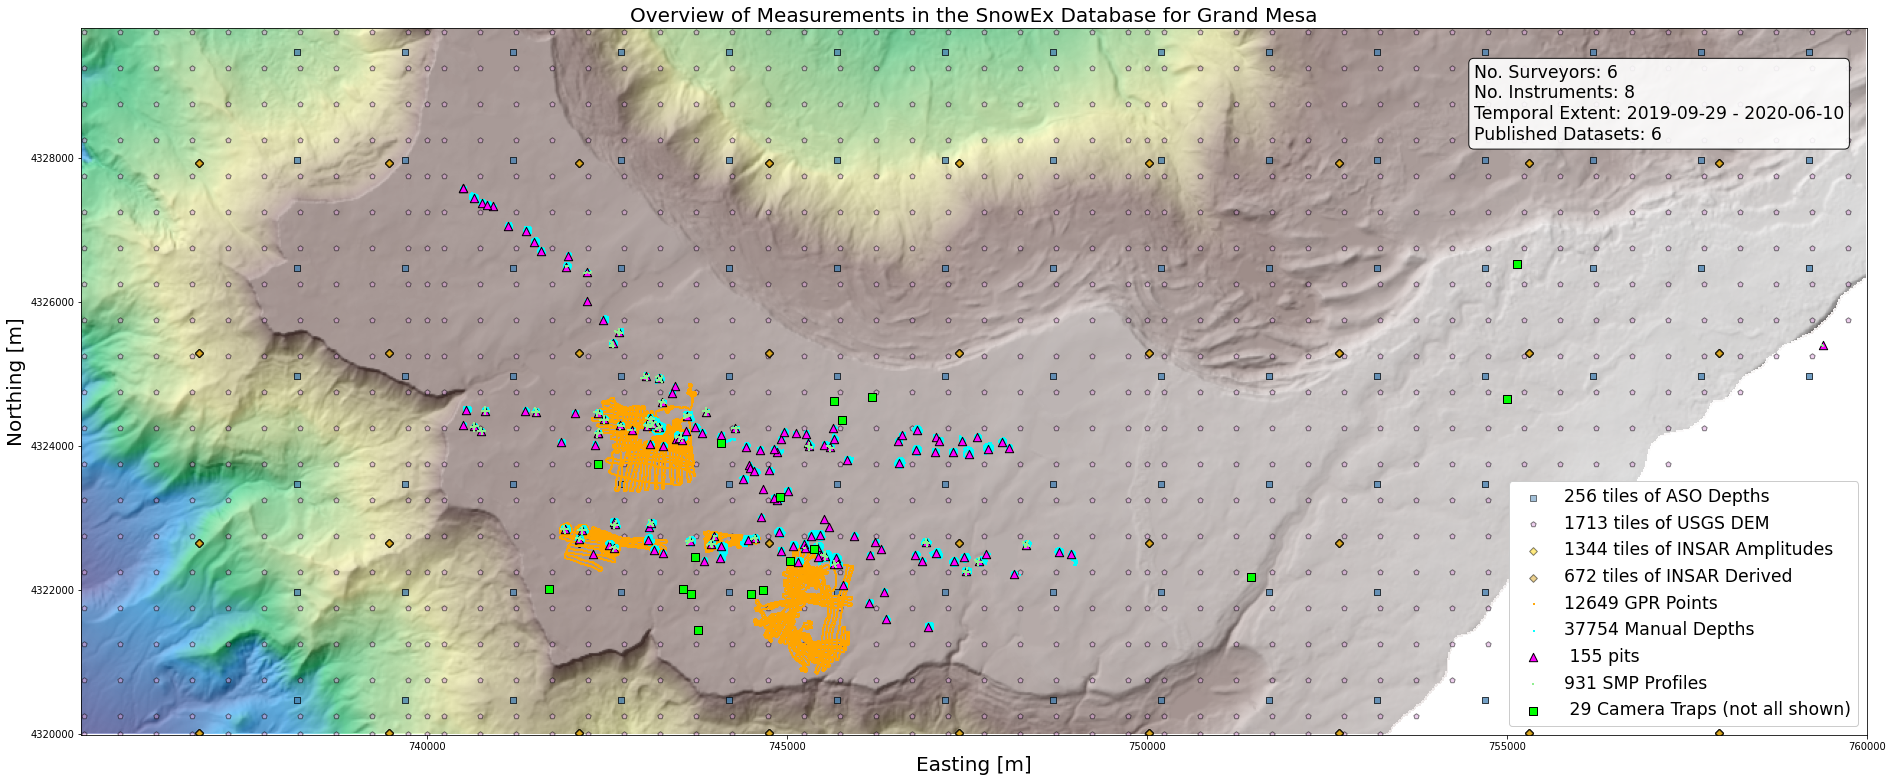

In [9]:
# Create a figure with one subplot. Give it size
fig, ax = plt.subplots(1,1, figsize=(32, 16))

# Plot the hillshade raster in gray
show(hillshade, ax=ax, cmap='gray', transform=hillshade.transform)

# Plot the DEM with partial transparency so the hillshade can be seen
show(dem, ax=ax, alpha=0.5, cmap='terrain', transform=dem.transform)

# Plot raster centers 
for n, d in tiles.items():
    df = d[0]
    color = d[1]
    marker = d[2]
    
    # Filter the data only to our map extent defined in the beginning
    ind = df.geometry.within(extent)
    
    # Plot with a name that shows the total tiles not just the tiles in the extent.
    df.loc[ind].plot(ax=ax, marker=marker, markersize=30, edgecolor='black', alpha=0.5,  color=color, label='{} tiles of {}'.format(len(df.index), n))

# Plot the GRP points as orange pixels
gpr.plot(ax=ax, marker=',' , color='orange', markersize=1, label='{} GPR Points'.format(len(gpr.index)))

# Plot the snow depths using aqua colored pixels
depths.plot(ax=ax, marker=',' , color='aqua', markersize=1, label='{} Manual Depths'.format(len(depths.index)))

# Plot the pits as magenta triangles 
pits.plot(ax=ax, marker='^' , color='magenta', edgecolor='black', markersize=70, label=' {} pits'.format(len(pits.index)))

# Plot the SMP positions with a red plus
smp.plot(ax=ax, marker='+' , color='lightgreen', markersize=5, label='{} SMP Profiles'.format(len(smp.index)))

# Plot the pits as magenta triangles 
cameras.plot(ax=ax, marker='s' , color='lime', edgecolor='black', markersize=70, label=' {} Camera Traps (not all shown)'.format(len(cameras.index)))

# Don't use scientific notation on the axis ticks
ax.ticklabel_format(style='plain', useOffset=False)

# Add some labeling
ax.legend(loc='lower right', fontsize='xx-large', framealpha=1.0)
ax.set_title('Overview of Measurements in the SnowEx Database for Grand Mesa', size=20)
ax.set_xlabel('Easting [m]', size=20)
ax.set_ylabel('Northing [m]', size=20)

ax.set_xlim([extent.bounds[0], extent.bounds[2]])
ax.set_ylim([extent.bounds[1], extent.bounds[3]])


# Add a block showing off details 


textstr = '\n'.join([f"No. observers: {metadata['observers']}",
                     f"No. Instruments: {metadata['instrument']}", 
                     f"Temporal Extent: {metadata['date'][0]} - {metadata['date'][1]}",
                     f"Published Datasets: {metadata['doi']}"])
    
props = dict(boxstyle='round', facecolor='white', alpha=0.9)

# place a text box in upper left in axes coords
s = ax.text(0.78, 0.95, textstr, transform=ax.transAxes, fontsize='xx-large',
        verticalalignment='top', bbox=props)


# Save the figure if you want
#plt.savefig('/SOME/LOCATION/')


In [10]:
session.close()